# Assignment 2.2

## Name: Oscar Bergling
## Id: a23Oscbe

## Course: Introduction to Data Science

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import mlflow
from mlflow.models import infer_signature

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner



import joblib

#Task 1

##1. Perform data preprocessing tasks such as handling missing values, encoding categorical variables, and scaling numerical features.


In [2]:
df = pd.read_csv("forestfires.csv")
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


##Info about the values:
Target value: area

Independent values: the rest

- x and y is coordinates. X should be between 1 and 9, Y between 2 and 9.
- FMMC = fine fuel moisture code: should be between 0-101
- DMC = Duff moisture code, open ended (no range of values).
- DC = Drought code: Max value of 1000
- ISI = Initital Spread Index, open ended.
- Temp = in celcius.
- RH = relative humidity, should be between 0 - 100 %.

The rest of the valus is self explainable.

Source:

https://archive.ics.uci.edu/dataset/162/forest+fires

https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system

In [3]:
#looking for missing values
df.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

No missing values.


In [4]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


- For X, Y, DC and RH which has limited range is within the range, thus has no outliers.
- DMC and ISI has a open end, thus hard to know if there is outlier or not, based on this tabel.
- Temp is in celcius and the range seems reasonable for regular temperature.
- Wind speed should also be reasonable with max of 9.4 and min of 0.4.
- Rain is also ok.
- Area is hard to know but can most likely be from very small to very large


I will look at DMC and ISI because these has no real range and is therefore important to see if they have potential outliers.

Text(0.5, 1.0, 'DMC')

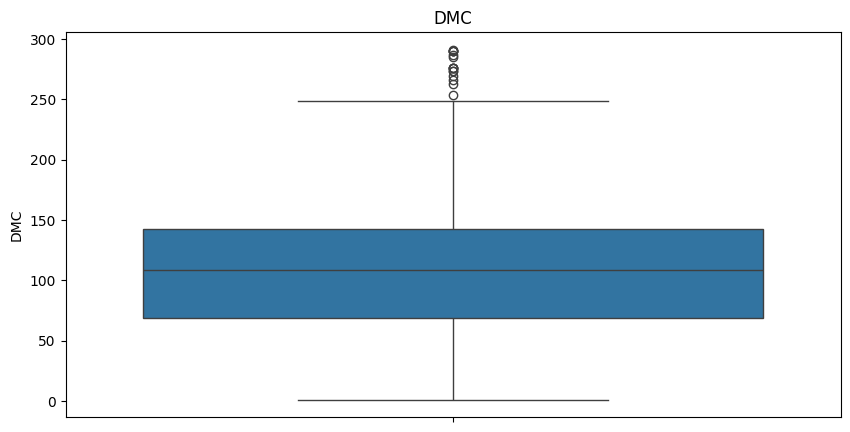

In [5]:
#look at DMC
plt.figure(figsize=(10,5))
sns.boxplot(data = df["DMC"])
plt.title("DMC")

<AxesSubplot: xlabel='DMC', ylabel='Count'>

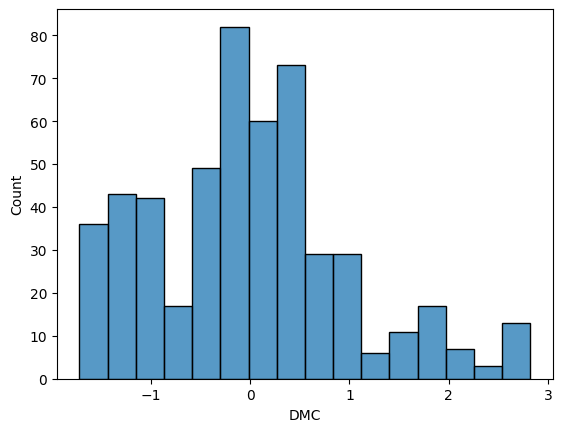

In [6]:
#see z-score
stats.zscore(df["DMC"])
sns.histplot(data = stats.zscore(df["DMC"]))

A datapoint further away from zero should indicate on a potential outlier however here can we see that it seems to be quite a lot of values that are deviating from zero. Thus, I believe that this can’t really be seen at outliers. First, many values would have been changed or removed, thus affecting the result. Second, because it is an open range for DMC do I think it's hard to know if it is an outlier or not. For a more depth understanding would it probably be better to ask an expert in this case.

Text(0.5, 1.0, 'ISI')

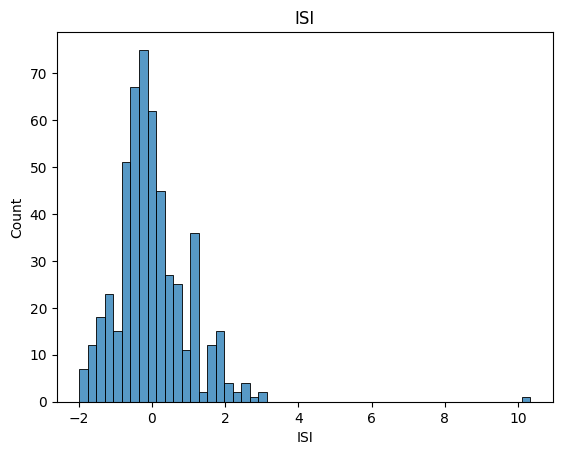

In [7]:
#look as ISI
stats.zscore(df["ISI"])
sns.histplot(data = stats.zscore(df["ISI"]))
plt.title("ISI")

For ISI can one outlier around 10 be seen. This one can be regarded as outlier. I will not remove this one because then a lot of values will be removed. Instead, will I take the average of the top 10 values and assign the outlier with that value.

In [8]:
#get values with zscore over 8
values = (stats.zscore(df["ISI"]))
high = df[values > 8]
high

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
22,7,4,jun,sun,94.3,96.3,200.0,56.1,21.0,44,4.5,0.0,0.0


In [9]:
#get top 10 largest values
df_top_10 = df.nlargest(10, "ISI")
df_top_10_mean = df_top_10["ISI"].mean()
df_top_10_mean

24.39

In [10]:
# row index = 22
df.loc[22, "ISI"] = df_top_10_mean

In [11]:
df.nlargest(10, "ISI")

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
22,7,4,jun,sun,94.3,96.3,200.0,24.39,21.0,44,4.5,0.0,0.00
266,6,5,aug,tue,94.3,131.7,607.1,22.70,19.4,55,4.0,0.0,0.17
11,7,5,sep,sat,92.8,73.2,713.0,22.60,19.3,38,4.0,0.0,0.00
485,2,4,aug,mon,95.0,135.5,596.3,21.30,30.6,28,3.6,0.0,2.07
24,7,4,aug,sat,93.5,139.4,594.2,20.30,23.7,32,5.8,0.0,0.00
135,3,5,aug,sat,93.5,139.4,594.2,20.30,17.6,52,5.8,0.0,0.00
206,2,2,aug,sat,93.5,139.4,594.2,20.30,22.9,31,7.2,0.0,15.45
211,7,4,aug,sat,93.5,139.4,594.2,20.30,5.1,96,5.8,0.0,26.00
503,2,4,aug,wed,94.5,139.4,689.1,20.00,29.2,30,4.9,0.0,1.95
504,4,3,aug,wed,94.5,139.4,689.1,20.00,28.9,29,4.9,0.0,49.59


Can see that it is changed.

Text(0.5, 1.0, 'ISI')

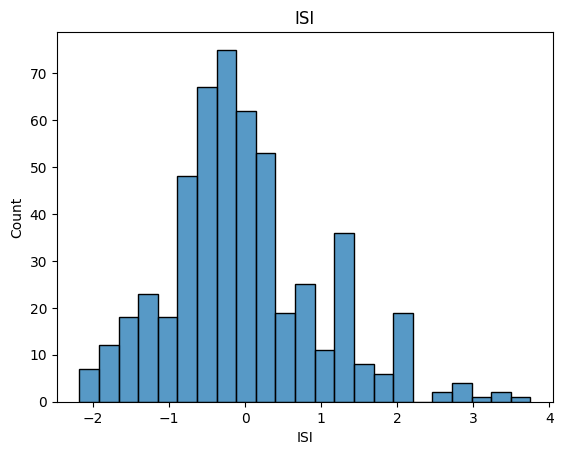

In [12]:
stats.zscore(df["ISI"])
sns.histplot(data = stats.zscore(df["ISI"]))
plt.title("ISI")

Now I believe the representation if much better. One could probably also argue that the values above 2 is also outliers, but I think that is hard to know. There is no real range for ISI and the values above 2 are also somewhat associated with the whole dataset. In an perfect scenario would it be great to talk with an expert for this.

## Scale
Can see that the numbers are in different sacles, so it makes sense to scale it down. I will use minmax scaler here. First I will encode the days and months.

Need to encode month and day. This will be done by converting them to repsepctive number.
Ex
- monday = 1, sunday = 7

- Jan = 1, Dec = 12

In [13]:
#get all month and days.
#change days
def encodeDays(day):
  if day == "mon":
    return 1
  elif day == "tue":
    return 2
  elif day == "wed":
    return 3
  elif day == "thu":
    return 4
  elif day == "fri":
    return 5
  elif day == "sat":
    return 6
  elif day == "sun":
    return 7

def encodeMonth(month):
  if month == "jan":
    return 1
  elif month == "feb":
    return 2
  elif month == "mar":
    return 3
  elif month == "apr":
    return 4
  elif month == "may":
    return 5
  elif month == "jun":
    return 6
  elif month == "jul":
    return 7
  elif month == "aug":
    return 8
  elif month == "oct":
    return 9
  elif month == "sep":
    return 10
  elif month == "nov":
    return 11
  elif month == "dec":
    return 12

df["day"] = df["day"].apply(encodeDays)
df["month"] = df["month"].apply(encodeMonth)


In [14]:

#scale data
scaler = MinMaxScaler()

features = list(df.columns)

for feature in features:
    transform = scaler.fit_transform(df[[feature]])
    df[feature] = transform

df


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,0.750,0.428571,0.181818,0.666667,0.870968,0.086492,0.101325,0.209102,0.192926,0.423529,0.700000,0.00000,0.000000
1,0.750,0.285714,0.727273,0.166667,0.927742,0.118194,0.775419,0.274703,0.508039,0.211765,0.055556,0.00000,0.000000
2,0.750,0.285714,0.727273,0.833333,0.927742,0.146795,0.796294,0.274703,0.398714,0.211765,0.100000,0.00000,0.000000
3,0.875,0.571429,0.181818,0.666667,0.941935,0.110958,0.081623,0.369004,0.196141,0.964706,0.400000,0.03125,0.000000
4,0.875,0.571429,0.181818,1.000000,0.910968,0.172984,0.110590,0.393604,0.295820,0.988235,0.155556,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,0.375,0.142857,0.636364,1.000000,0.811613,0.191592,0.771315,0.077901,0.823151,0.200000,0.255556,0.00000,0.005904
513,0.125,0.285714,0.636364,1.000000,0.811613,0.191592,0.771315,0.077901,0.633441,0.658824,0.600000,0.00000,0.049769
514,0.750,0.285714,0.636364,1.000000,0.811613,0.191592,0.771315,0.077901,0.610932,0.647059,0.700000,0.00000,0.010231
515,0.000,0.285714,0.636364,0.833333,0.976774,0.499311,0.711622,0.463305,0.752412,0.317647,0.400000,0.00000,0.000000


<AxesSubplot: >

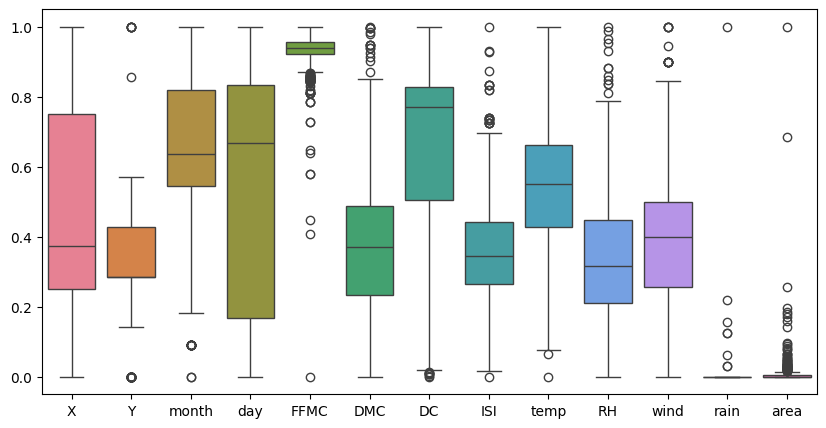

In [15]:
plt.figure(figsize = (10,5))
sns.boxplot(data = df[list(df.columns)])

Here is a better picture.

As stated before should there not be any real outlier, based on the information about the variables. The only two variabels that could potential have outliers is DMC and ISI, which was fixed before.

## Look at the correlation and covariance

<AxesSubplot: >

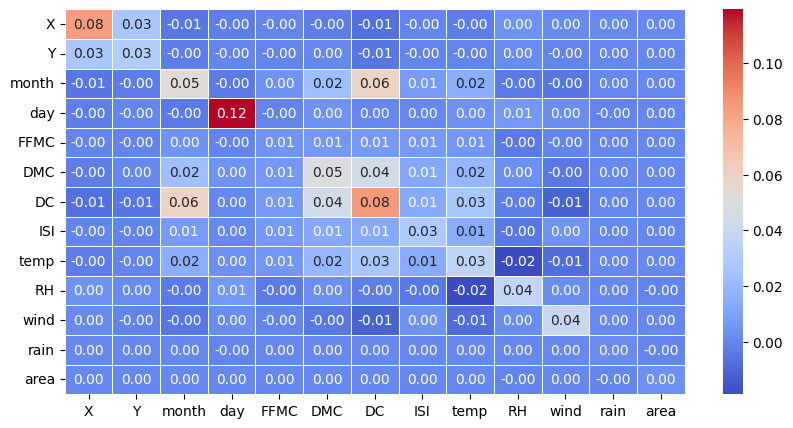

In [16]:
# heatmap with cov
plt.figure(figsize = (10,5))
sns.heatmap(df.cov(), cmap="coolwarm", annot = True, fmt=".2f", linewidths=.5 )

The covariance is nothing special here. There are zero covariance between the target value (area) and the rest of the independent variabels. The variables does therefore not vary in the same directions nor the opposite direction.

<AxesSubplot: >

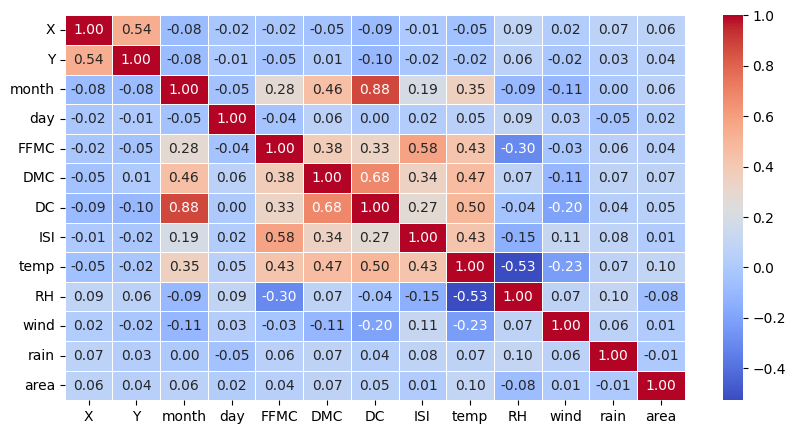

In [17]:
#correlation heatmap, default pearson correlation
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(), cmap="coolwarm", annot = True, fmt=".2f", linewidths=.5 )

<AxesSubplot: >

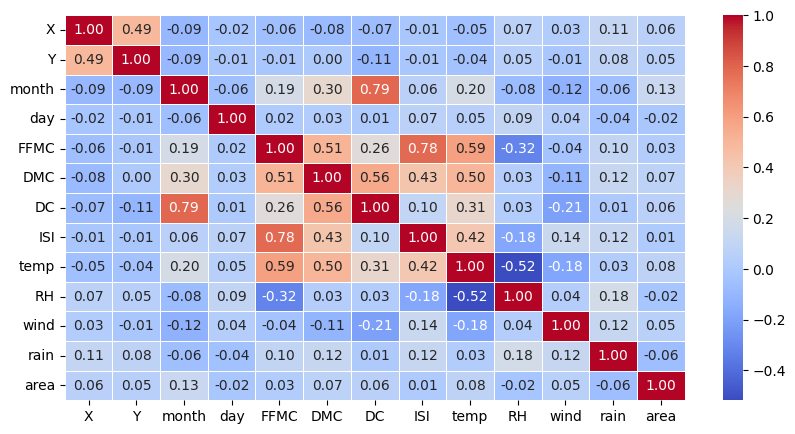

In [18]:
#correlation heatmap
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(method = "spearman"), cmap="coolwarm", annot = True, fmt=".2f", linewidths=.5 )

Can see for both pearson correlation and spearman correlation that the correlation between the target value and non-dependent values have a low correlation. I therefore think that there is no linear relationship between the values.

Another interesting thing is that there seems to be correlations between some independent values, this could potentially affect the result. This can be seen in both Person and Spearman.


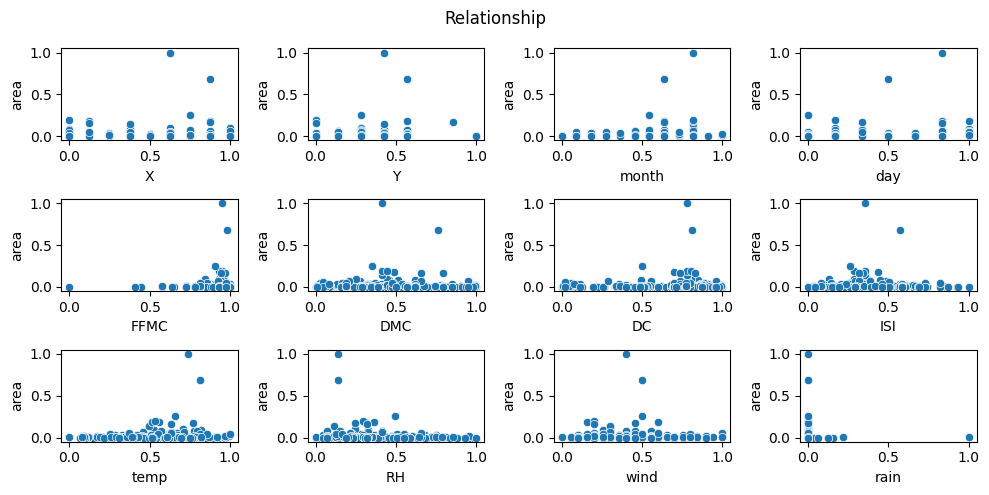

In [19]:
fig, axs = plt.subplots(3,4, figsize=(10,5))

sns.scatterplot(data = df, x = "X", y = "area",ax = axs[0,0])
sns.scatterplot(data = df, x = "Y", y = "area",ax = axs[0,1])
sns.scatterplot(data = df, x = "month", y = "area",ax = axs[0,2])
sns.scatterplot(data = df, x = "day", y = "area",ax = axs[0,3])

sns.scatterplot(data = df, x = "FFMC", y = "area",ax = axs[1,0])
sns.scatterplot(data = df, x = "DMC", y = "area",ax = axs[1,1])
sns.scatterplot(data = df, x = "DC", y = "area",ax = axs[1,2])
sns.scatterplot(data = df, x = "ISI", y = "area",ax = axs[1,3])

sns.scatterplot(data = df, x = "temp", y = "area",ax = axs[2,0])
sns.scatterplot(data = df, x = "RH", y = "area",ax = axs[2,1])
sns.scatterplot(data = df, x = "wind", y = "area",ax = axs[2,2])
sns.scatterplot(data = df, x = "rain", y = "area",ax = axs[2,3])

fig.suptitle("Relationship")
plt.tight_layout()

Can also see from the scatter plot that a linear relationship is not really present.

## Look at the distribution

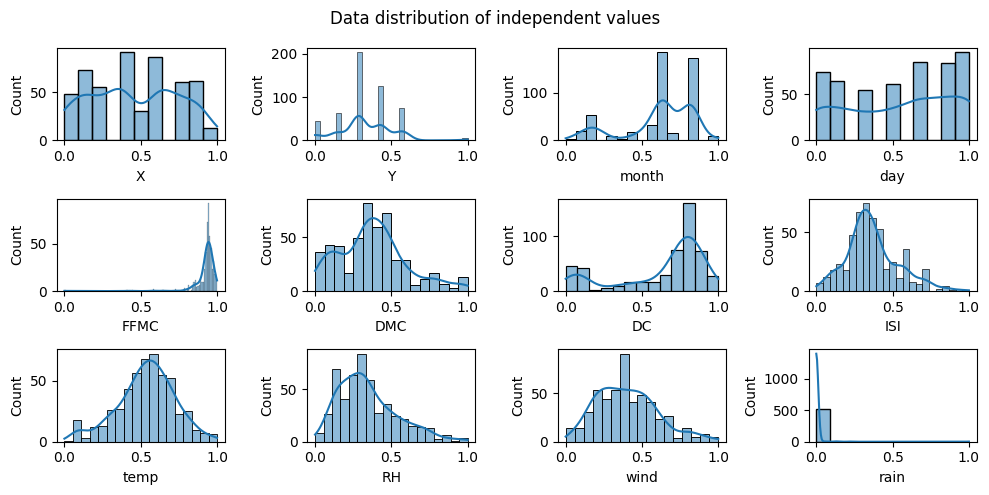

In [20]:
fig, axs = plt.subplots(3,4, figsize=(10,5))

sns.histplot(data = df, x = "X", ax = axs[0,0], kde = True)
sns.histplot(data = df, x = "Y", ax = axs[0,1], kde = True)
sns.histplot(data = df, x = "month", ax = axs[0,2], kde = True)
sns.histplot(data = df, x = "day", ax = axs[0,3], kde = True)

sns.histplot(data = df, x = "FFMC", ax = axs[1,0], kde = True)
sns.histplot(data = df, x = "DMC", ax = axs[1,1], kde = True)
sns.histplot(data = df, x = "DC", ax = axs[1,2], kde = True)
sns.histplot(data = df, x = "ISI", ax = axs[1,3], kde = True)

sns.histplot(data = df, x = "temp", ax = axs[2,0], kde = True)
sns.histplot(data = df, x = "RH", ax = axs[2,1], kde = True)
sns.histplot(data = df, x = "wind", ax = axs[2,2], kde = True)
sns.histplot(data = df, x = "rain", ax = axs[2,3], kde = True)

plt.suptitle("Data distribution of independent values")

plt.tight_layout()

Can see that some values are abit skewed.

Text(0.5, 1.0, 'Area')

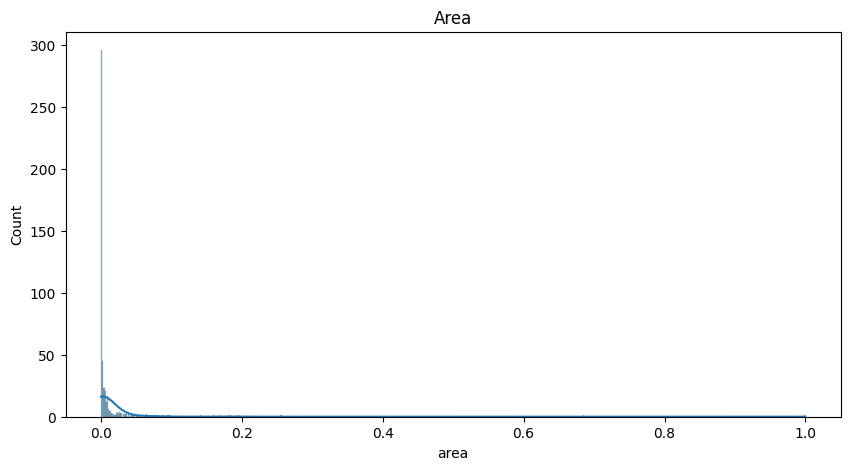

In [21]:
fig, axs = plt.subplots(figsize=(10,5))

sns.histplot(data = df, x = "area", kde = True)
plt.title("Area")

Area is also skewed. 

## 2. Use a neural network framework (e.g., TensorFlow or PyTorch) to build a regression model. Explain the choice of architecture, and activation functions

Will first use keras tune to find the best hyperparameters for the neural network, I will then use these parameters to build a model and test it.

Soruces:
https://www.tensorflow.org/tutorials/keras/keras_tuner

https://keras.io/keras_tuner/  

https://www.tensorflow.org/tutorials/keras/keras_tuner

https://keras.io/keras_tuner/

https://keras.io/guides/keras_tuner/getting_started/

In [22]:
#get independent variables
x_names = list(df.columns)
x_names.remove("area")
y_names = "area"

#split data
x = df[x_names]
y = df[y_names]

x_train, x_values, y_train, y_values = train_test_split(x, y, test_size = 0.3, random_state = 42)

x_val, x_test, y_val, y_test = train_test_split(x_values, y_values, test_size = 0.5, random_state = 42)

### Finetune the model with keras tune (No transformation)

In [23]:
#fine tune the model with keras tune

#create model
def model(hp): #hp = hypertuning
  model = keras.Sequential()

  #input layers
  model.add(layers.Dense(units = hp.Int("units_input", min_value = 32, max_value = 128, step = 32), activation = hp.Choice("activation_input", values = ["relu","tanh","sigmoid"]), input_shape = (x_train.shape[1],)))

  #hidden layers
  for i in range(hp.Int("num_layers", 1, 10)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=128, step=32),
                activation=hp.Choice("activation", ["relu", "tanh","sigmoid"]),
            )
        )
  #output layers, regression --> 1 neuron.
  model.add(layers.Dense(units=1, activation=hp.Choice('activation_output', values=['linear', 'relu', 'tanh'])))

  #optimze the learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

  #build the model
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss = "mean_squared_error")

  return model

tuner = keras_tuner.RandomSearch(
    model,
    objective='val_loss',
    max_trials=20,
    directory='my_dir_1',
    project_name='my_project_1'
    )


#get best parameters
tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
best_hyperparameters = tuner.get_best_hyperparameters()[0]

best_hyperparameters.values


Reloading Tuner from my_dir_1\my_project_1\tuner0.json


{'units_input': 128,
 'activation_input': 'relu',
 'num_layers': 7,
 'units_0': 32,
 'activation': 'relu',
 'activation_output': 'linear',
 'learning_rate': 0.0001,
 'units_1': 128,
 'units_2': 32,
 'units_3': 32,
 'units_4': 64,
 'units_5': 64,
 'units_6': 64,
 'units_7': 64,
 'units_8': 64,
 'units_9': 128}

***Build a new model with the best parameters and test it***

In [24]:

best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = optimizer, loss = "mean_squared_error")

early_stopping = EarlyStopping(monitor='val_loss', patience=10)


hist = model.fit(x_train, y_train, epochs = 500, validation_data=(x_val, y_val), callbacks = [early_stopping])

# save model
filename = "NN_ForestFires.h5"
model.save(filename)


Epoch 1/500

12/12 [==============================] - 3s 30ms/step - loss: 0.0065 - val_loss: 6.0456e-04
Epoch 2/500
12/12 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 6.0702e-04
Epoch 3/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 6.1927e-04
Epoch 4/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 6.8364e-04
Epoch 5/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 6.0982e-04
Epoch 6/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 6.7341e-04
Epoch 7/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 6.0976e-04
Epoch 8/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 6.8227e-04
Epoch 9/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 6.0637e-04
Epoch 10/500
12/12 [==============================] - 0s 5ms/step - lo

c:\Users\osci1\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


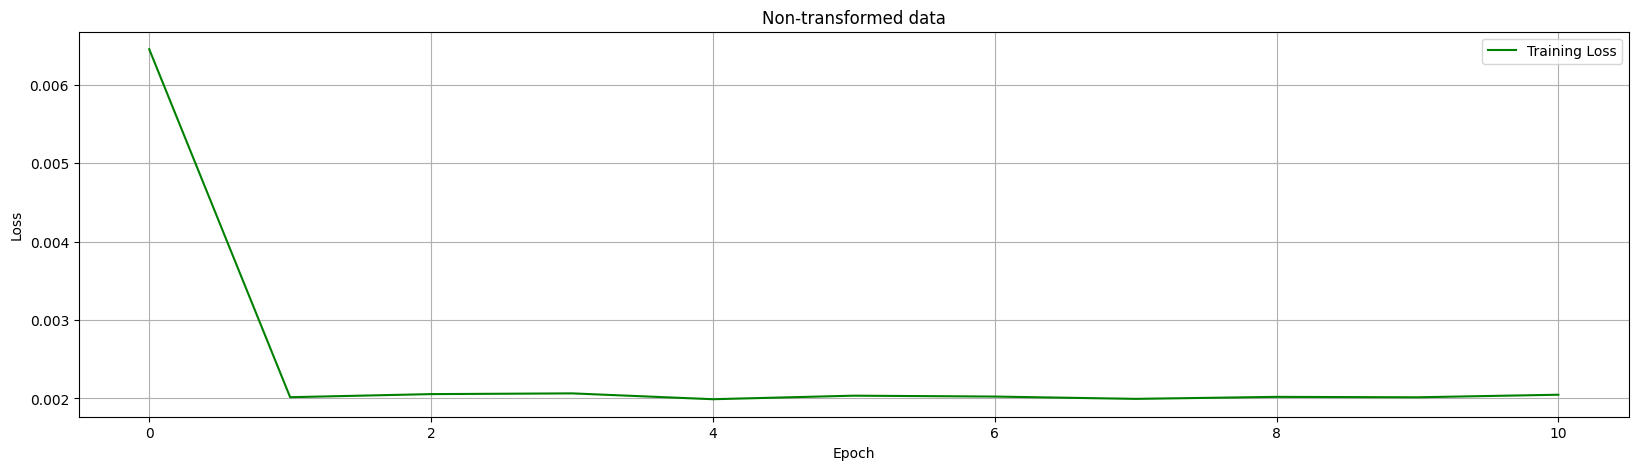

In [25]:
plt.figure(figsize=(20,5))
plt.plot(hist.history['loss'], 'g', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Non-transformed data")
plt.legend()
plt.grid(True)

## 3. Result for first model: Evaluate the model's performance on the testing dataset using appropriate metrics

In [26]:
#test model
y_pred = model.predict(x_test)

#get mse and r^2
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


3/3 [==============================] - 0s 3ms/step
R-squared: -0.0008615352588361436
Mean Squared Error: 0.012742745616535664


Got quite bad result. The model should be tuned for the best hyperparameters, but it could be that the data is skewed and thus affect the result. I will therefore test to transform the data to a better distribution. This is done with log and square depending on how it is skewed.

It is FFMc, Y, month, DMC, DC, ISI, RH, rain and area that is the most skewed.

### Transform data

Will transform the right skewed with log and left skewed with square.

Soruce: https://www.kaggle.com/code/aimack/how-to-handle-skewed-distribution

In [27]:
transform_right = ["ISI","RH","rain", "area","DMC"]


transform_left = ["FFMC","DC"]

df[transform_right] = np.log1p(df[transform_right])
df[transform_left] = np.square(df[transform_left])
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,0.750,0.428571,0.181818,0.666667,0.758585,0.082954,0.010267,0.189878,0.192926,0.353139,0.700000,0.000000,0.000000
1,0.750,0.285714,0.727273,0.166667,0.860705,0.111715,0.601275,0.242713,0.508039,0.192078,0.055556,0.000000,0.000000
2,0.750,0.285714,0.727273,0.833333,0.860705,0.136971,0.634084,0.242713,0.398714,0.192078,0.100000,0.000000,0.000000
3,0.875,0.571429,0.181818,0.666667,0.887242,0.105223,0.006662,0.314083,0.196141,0.675343,0.400000,0.030772,0.000000
4,0.875,0.571429,0.181818,1.000000,0.829862,0.159551,0.012230,0.331893,0.295820,0.687247,0.155556,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,0.375,0.142857,0.636364,1.000000,0.658716,0.175290,0.594926,0.075015,0.823151,0.182322,0.255556,0.000000,0.005886
513,0.125,0.285714,0.636364,1.000000,0.658716,0.175290,0.594926,0.075015,0.633441,0.506109,0.600000,0.000000,0.048570
514,0.750,0.285714,0.636364,1.000000,0.658716,0.175290,0.594926,0.075015,0.610932,0.498991,0.700000,0.000000,0.010179
515,0.000,0.285714,0.636364,0.833333,0.954088,0.405006,0.506406,0.380697,0.752412,0.275848,0.400000,0.000000,0.000000


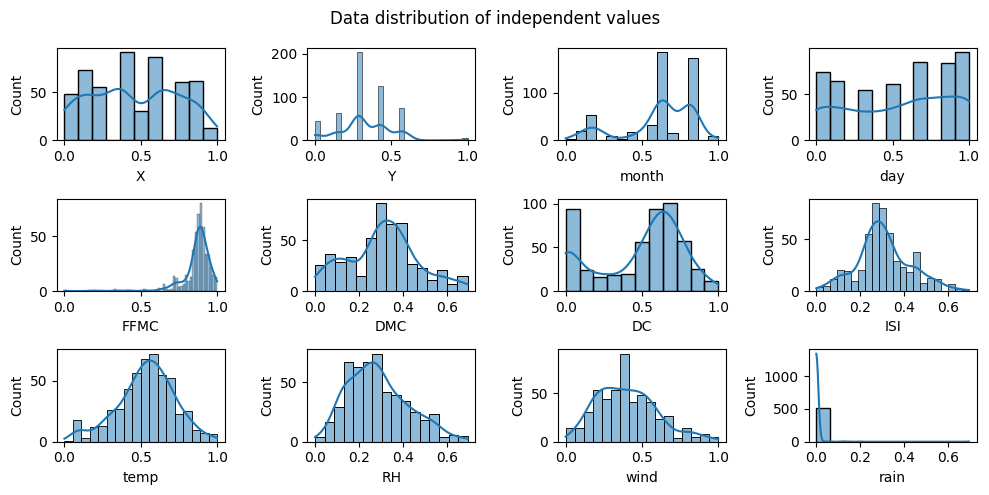

In [28]:
fig, axs = plt.subplots(3,4, figsize=(10,5))

sns.histplot(data = df, x = "X", ax = axs[0,0], kde = True)
sns.histplot(data = df, x = "Y", ax = axs[0,1], kde = True)
sns.histplot(data = df, x = "month", ax = axs[0,2], kde = True)
sns.histplot(data = df, x = "day", ax = axs[0,3], kde = True)

sns.histplot(data = df, x = "FFMC", ax = axs[1,0], kde = True)
sns.histplot(data = df, x = "DMC", ax = axs[1,1], kde = True)
sns.histplot(data = df, x = "DC", ax = axs[1,2], kde = True)
sns.histplot(data = df, x = "ISI", ax = axs[1,3], kde = True)

sns.histplot(data = df, x = "temp", ax = axs[2,0], kde = True)
sns.histplot(data = df, x = "RH", ax = axs[2,1], kde = True)
sns.histplot(data = df, x = "wind", ax = axs[2,2], kde = True)
sns.histplot(data = df, x = "rain", ax = axs[2,3], kde = True)

plt.suptitle("Data distribution of independent values")

plt.tight_layout()

Got a little better data.

<AxesSubplot: xlabel='area', ylabel='Count'>

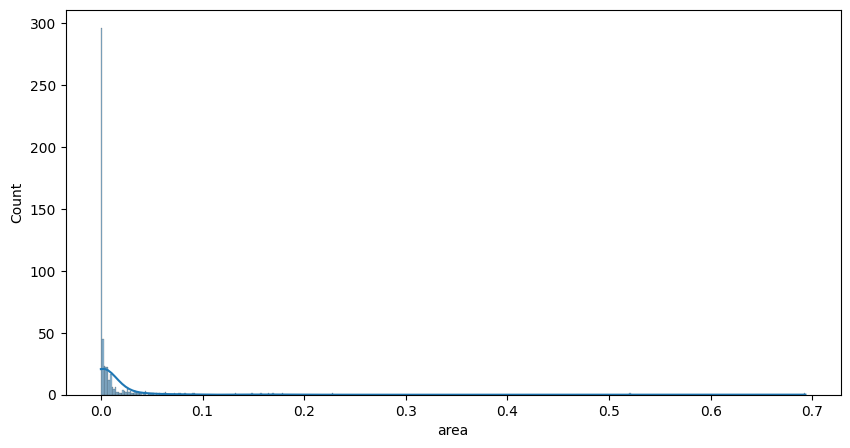

In [29]:
fig, axs = plt.subplots(figsize=(10,5))

sns.histplot(data = df, x = "area", kde = True)

In [30]:
#get independent variables
x_names = list(df.columns)
x_names.remove("area")
y_names = "area"

#split data
x = df[x_names]
y = df[y_names]

x_train, x_values, y_train, y_values = train_test_split(x, y, test_size = 0.3, random_state = 42)

x_val, x_test, y_val, y_test = train_test_split(x_values, y_values, test_size = 0.5, random_state = 42)

### Finetune the model with keras tune (Transformation)

In [31]:
#create model
def model(hp): #hp = hypertuning
  model = keras.Sequential()

  #input layers
  model.add(layers.Dense(units = hp.Int("units_input", min_value = 32, max_value = 128, step = 32), activation = hp.Choice("activation_input", values = ["relu","tanh","sigmoid"]), input_shape = (x_train.shape[1],)))

  #hidden layers
  for i in range(hp.Int("num_layers", 1, 10)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=128, step=32),
                activation=hp.Choice("activation", ["relu", "tanh","sigmoid"]),
            )
        )
  #output layers, regression --> 1 neuron.
  model.add(layers.Dense(units=1, activation=hp.Choice('activation_output', values=['linear', 'relu', 'tanh'])))

  #optimze the learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  #build the model
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss = "mean_squared_error")

  return model

tuner = keras_tuner.RandomSearch(
    model,
    objective='val_loss',
    max_trials=20,
    directory='my_dir_2',
    project_name='my_project_2')


#get best parameters
tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

parameters = tuner.get_best_hyperparameters()[0]
parameters.values

Reloading Tuner from my_dir_2\my_project_2\tuner0.json


{'units_input': 96,
 'activation_input': 'sigmoid',
 'num_layers': 5,
 'units_0': 128,
 'activation': 'relu',
 'activation_output': 'linear',
 'learning_rate': 0.0001,
 'units_1': 96,
 'units_2': 32,
 'units_3': 96,
 'units_4': 128,
 'units_5': 64,
 'units_6': 32,
 'units_7': 128,
 'units_8': 32}

In [32]:
#build a new model with the best parameters and test.
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss = "mean_squared_error")

early_stopping = EarlyStopping(monitor='loss', patience=10)

hist = model.fit(x_train, y_train, epochs = 500, validation_data=(x_val, y_val) ,callbacks = [early_stopping])

Epoch 1/500
12/12 [==============================] - 2s 26ms/step - loss: 0.0017 - val_loss: 8.5728e-04
Epoch 2/500
12/12 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 6.4916e-04
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 7.1104e-04
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 5.8378e-04
Epoch 5/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 5.3656e-04
Epoch 6/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 5.5315e-04
Epoch 7/500
12/12 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 5.3299e-04
Epoch 8/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 5.7307e-04
Epoch 9/500
12/12 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 5.3553e-04
Epoch 10/500
12/12 [==============================] - 0s 13ms/step - 

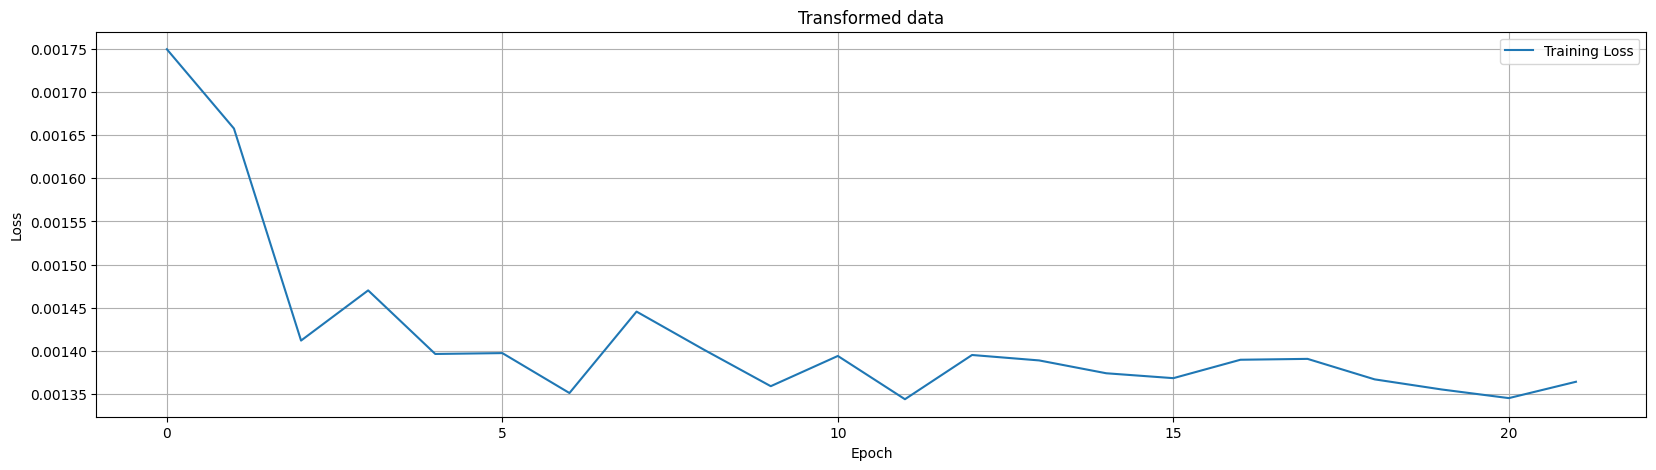

In [33]:
plt.figure(figsize=(20,5))
plt.plot(hist.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Transformed data")
plt.legend()
plt.grid(True)

## 3. Result for the second model: Evaluate the model's performance on the testing dataset using appropriate metrics

In [34]:
#test model
y_pred = model.predict(x_test)

#get mse and r^2
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

3/3 [==============================] - 0s 16ms/step
R-squared: 0.0022006031050193497
Mean Squared Error: 0.006172218519302304


Got no real different between the values when the data is transformed and not.

## Feature selection

I will try to look what features are important for the prediction. This will be done with randomforestregression.

It should use gini importance. Higher value more important feature.


Source: https://machinelearningmastery.com/calculate-feature-importance-with-python/

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_

In [35]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

rfr.fit(x_train, y_train)

important = rfr.feature_importances_

for num, value in enumerate(important):
  print(num, value)

0 0.05745822276815641
1 0.08774089835776645
2 0.012381314286141731
3 0.04486693144590708
4 0.06382455313576456
5 0.24551675688426267
6 0.07423003996529472
7 0.03862194627779366
8 0.18321379600220786
9 0.12876680861478348
10 0.06326846972424915
11 0.00011026253767223521


Can see that feature 5, 8 and 9 seems to be the most important features. This should be feature: DMC, temp and RH.

I will build a model based on these futures and test.

In [36]:
#x values
x_imp = df[["DMC","temp","RH"]]
y = df[["area"]]

x_train, x_values, y_train, y_values = train_test_split(x_imp, y, test_size = 0.3, random_state = 42)

x_val, x_test, y_val, y_test = train_test_split(x_values, y_values, test_size = 0.5, random_state = 42)

In [37]:
#create model
def model(hp): #hp = hypertuning
  model = keras.Sequential()

  #input layers
  model.add(layers.Dense(units = hp.Int("units_input", min_value = 32, max_value = 128, step = 32), activation = hp.Choice("activation_input", values = ["relu","tanh","sigmoid"]), input_shape = (x_train.shape[1],)))

  #hidden layers
  for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=128, step=32),
                activation=hp.Choice("activation", ["relu", "tanh","sigmoid"]),
            )
        )
  #output layers, regression --> 1 neuron.
  model.add(layers.Dense(units=1, activation=hp.Choice('activation_output', values=['linear', 'relu', 'tanh'])))

  #optimze the learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

  #build the model
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss = "mean_squared_error")

  return model

tuner = keras_tuner.RandomSearch(
    model,
    objective='val_loss',
    max_trials=20,
    directory='my_dir_2',
    project_name='my_project_2')


#get best parameters
tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

best_hyperparameters = tuner.oracle.get_best_trials(1)[0].hyperparameters.values

for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Reloading Tuner from my_dir_2\my_project_2\tuner0.json
units_input: 96
activation_input: sigmoid
num_layers: 5
units_0: 128
activation: relu
activation_output: linear
learning_rate: 0.0001
units_1: 96
units_2: 32
units_3: 96
units_4: 128
units_5: 64
units_6: 32
units_7: 128
units_8: 32


In [38]:
#build a new model with the best parameters and test.
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss = "mean_squared_error")

early_stopping = EarlyStopping(monitor='loss', patience=10)
callback = [early_stopping]

hist = model.fit(x_train, y_train, epochs = 500, validation_data=(x_val, y_val) ,callbacks = [callback])

Epoch 1/500
12/12 [==============================] - 2s 25ms/step - loss: 0.0072 - val_loss: 0.0010
Epoch 2/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 5.3696e-04
Epoch 3/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 5.2488e-04
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 5.9435e-04
Epoch 5/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 7.0365e-04
Epoch 6/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 5.3012e-04
Epoch 7/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 6.7784e-04
Epoch 8/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 6.8960e-04
Epoch 9/500
12/12 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 5.6297e-04
Epoch 10/500
12/12 [==============================] - 0s 8ms/step - loss: 0.

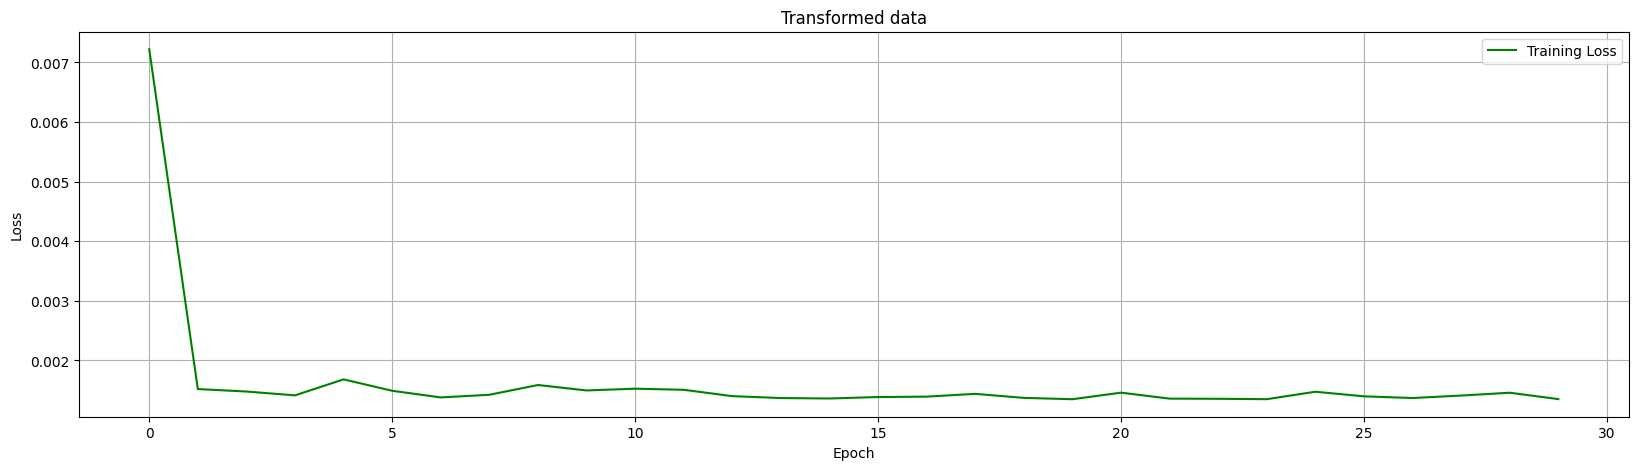

In [39]:
plt.figure(figsize=(20,5))
plt.plot(hist.history['loss'], 'g', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Transformed data")
plt.legend()
plt.grid(True)

In [40]:
#test model
y_pred = model.predict(x_values)

#get mse and r^2
r_squared = r2_score(y_values, y_pred)
print(f'R-squared: {r_squared}')

mse = mean_squared_error(y_values, y_pred)
print(f'Mean Squared Error: {mse}')

5/5 [==============================] - 0s 2ms/step
R-squared: 0.0013674547989187547
Mean Squared Error: 0.0033557407677278217


Can see that the result did not really matter in this case, thus these 3 variables is most likely those that affect the regression most. Can also see that the other non-important features did not affect the result in a bad way. The result was equal bad.

## 4. Predict with new data: Utilize the trained model to make predictions on fresh, unseen data points.

In [41]:
#load model
NN_model = tf.keras.models.load_model("NN_ForestFires.h5")

data = {    "X": 1,
            "Y": 2,
            "month": 3,
            "day": 4,
            "FFMC": 5,
            "DMC": 6,
            "DC": 7,
            "ISI": 8,
            "temp": 9,
            "RH": 10,
            "wind": 11,
            "rain": 12
            }

df_test_data = pd.DataFrame([data])
df_test_data
predicted_value = NN_model.predict(df_test_data)
predicted_value

1/1 [==============================] - 0s 154ms/step


array([[0.01482382]], dtype=float32)

## Comment

For both models was no real improvement done. Both gave bad result, where the R2 value was low, same with mse. This indicate that the model is bad at predicting the forest fires. The model seems not to fit good to the data. Can also see that what kind of features that are used does not affect the result, this can be seen from the feature selection.

It could be that the model needs more data to train on.
Even if the data is transformed is it still quite skewed, thus this could maybe affect the result. It can also be seen that the correlation between the independent values and the target values are non. This indicates that the data is nonlinear, but I think neural network should work anyways. It could be that the correlation between the independent values will affect the result. Hyperparameter tuning was done, thus this should not affect the result too much. It could be possibly to tune it even more.


# Task 2

## Question 1:
- Investigate MLflow and its significance in managing the end-to-end DS lifecycle,
including experiment tracking, model packaging, and deployment

MLflow is an opensource platform used to easier save, share, track and deploy different kind of models. With the tracking part can one save parameters, code versions, metrics etc which can be saved and later used for visualization. Can create several runs which measure the parameters and store these in an experiment. In the context of model packaging can one save and store the model, with its parameters, metrics, files etc where the model can later be used by other users. MLflow can also help with deploymnet, where the packaged model can be access by other users.

Sources: https://mlflow.org/docs/latest/tracking.html https://docs.databricks.com/en/mlflow/index.html https://mlflow.org/docs/latest/models.html https://mlflow.org/docs/latest/deployment/deploy-model-to-kubernetes/index.html

## Question 2
- Demonstrate how to log experiments, parameters and metrics, using MLflow during
the model development process.

I Have followed this guid: https://mlflow.org/docs/latest/getting-started/intro-quickstart/index.html

The same dataset is used, and a random neural network is used, only for demostration.

In [42]:
#get independent variables
x_names = list(df.columns)
x_names.remove("area")
y_names = "area"

#split data
x = df[x_names]
y = df[y_names]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

#create and train model

parameters = {
    "units_input": 128,
    "activation_input": "tanh",
    "num_layers": 1,
    "units_0": 64,
    "activation": "sigmoid",
    "activation_output": "tanh",
    "units_output": 1,
    "learning_rate": 0.001,
}

model = keras.Sequential()
    #first layer
    
model.add(layers.Dense(parameters["units_input"], activation = parameters["activation_input"], input_shape = (x_train.shape[1],)))
    
for i in range(parameters["num_layers"]):
  model.add(layers.Dense(parameters[f"units_{i}"], activation = parameters["activation"]))

#output layer
model.add(layers.Dense(parameters["units_output"], activation = parameters["activation_output"]))

optimizer = keras.optimizers.Adam(learning_rate= parameters["learning_rate"])
model.compile(optimizer = optimizer, loss = "mean_squared_error")

hist = model.fit(x_train, y_train, epochs = 20)

#test model
y_pred = model.predict(x_test)

#get mse and r^2
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Epoch 1/20
12/12 [==============================] - 1s 2ms/step - loss: 0.3006
Epoch 2/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0654
Epoch 3/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 4/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 5/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 6/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 7/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 8/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 9/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 10/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 11/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 12/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 13/20
12/12 [==============================

Must first call: mlflow server --host 127.0.0.1 --port 8080 in terminal to set up the server

In [43]:
#access the server
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [45]:
#create experiment
mlflow.set_experiment(experiment_name = "Test 1 neural network")

In [ ]:
with mlflow.start_run(run_name = "first test"):
    #log parameters
    mlflow.log_params(parameters)
    #log metrics
    mlflow.log_metric("R2", r_squared)
    mlflow.log_metric("MSE", mse)

    #set a tag for information about this run
    mlflow.set_tag("Training info","This was the first test with mlflow, model uses forestfire as dataset")

    mlflow.tensorflow.log_model(model, artifact_path = "first neural network",
        registered_model_name="Neural network")

2023/12/19 16:51:36 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2023/12/19 16:51:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc 

INFO:tensorflow:Assets written to: C:\Users\osci1\AppData\Local\Temp\tmpj3kmkv21\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\osci1\AppData\Local\Temp\tmpj3kmkv21\model\data\model\assets
c:\Users\osci1\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Neural network' already exists. Creating a new version of this model...
2023/12/19 16:52:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Neural network, version 4
Created version '4' of model 'Neural network'.


## Question 3

- Choose a deployment method and provide step-by-step instructions on how to deploy
the trained model in Task 1 (Flask, FastAPI, UI, etc.)

This question can be seen in the modelAPI.py file. An API is created where an end user can send in parameters in an json form and recive the predicted value. This is done wiht flask. 

I then tested the api with Postman and an picture ("postman_result") is included which shows the final result. 

The step to step instructions:
    First I need to create the Flask class. Which is where we tell flask where to find our resources. 
    Need to have a rout which tells flask what kind of url should be used to start a specific function. 
    A user can then access this model by sending an http request to the specific route. 

Source: https://flask.palletsprojects.com/en/3.0.x/quickstart/ 